# Домашнее задание № 8

## Задание 1 (4 балла) 

Обучите 8 моделей для задачи классификации текста (датасет - lenta_40k ). А именно:  
1) модель с 1 GRU слоем;   
2) модель с 1 LSTM слоем    
3) модель с 1 GRU и 1 LSTM слоем  
4) модель с 1 BIGRU и 2 LSTM слоями  
5) модель с 5 GRU слоями и 3 LSTM слоями  
6) модель 1 BIGRU и 1 BILSTM слоями, причем так чтобы модели для forward и backward прохода отличались   
7) модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM  
8) модель с 50 любыми рекуррентными слоями  


Параметр units и размер эмбединга можете задать любой. Оцените качество каждой модели и определите победителя.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
from IPython.display import Image
from IPython.core.display import HTML 
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = pd.read_csv('lenta_40k.csv.zip')

In [4]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [5]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [6]:
# словарь
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [7]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [8]:
# индексируем слова
word2id = {'PAD':0, 'UNK':1}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [9]:
id2word = {i:word for word, i in word2id.items()}

In [10]:
# переводим тексты в последовательности индексов
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [11]:
MAX_LEN = max(len(x) for x in X)

In [12]:
MEAN_LEN = np.median([len(x) for x in X])
MAX_LEN = int(MEAN_LEN + 30)

In [13]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [14]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [15]:
y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

# 1 GRU layer

Epoch 1/10
43/43 [==============================] - 53s 1s/step - loss: 2.5991 - f1: 0.0048 - rec@prec: 2.3732e-05 - val_loss: 2.3583 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/10
43/43 [==============================] - 51s 1s/step - loss: 2.2933 - f1: 0.0000e+00 - rec@prec: 7.1195e-05 - val_loss: 2.2431 - val_f1: 0.0000e+00 - val_rec@prec: 4.5086e-04
Epoch 3/10
43/43 [==============================] - 51s 1s/step - loss: 2.1491 - f1: 7.0597e-04 - rec@prec: 7.1195e-04 - val_loss: 2.0890 - val_f1: 0.0033 - val_rec@prec: 0.0045
Epoch 4/10
43/43 [==============================] - 54s 1s/step - loss: 1.9316 - f1: 0.0527 - rec@prec: 0.0129 - val_loss: 1.9093 - val_f1: 0.1127 - val_rec@prec: 0.0334
Epoch 5/10
43/43 [==============================] - 53s 1s/step - loss: 1.6873 - f1: 0.2229 - rec@prec: 0.1050 - val_loss: 1.8096 - val_f1: 0.2046 - val_rec@prec: 0.0600
Epoch 6/10
43/43 [==============================] - 52s 1s/step - loss: 1.5008 - f1: 0.3513 - rec@prec: 0.2106 - v

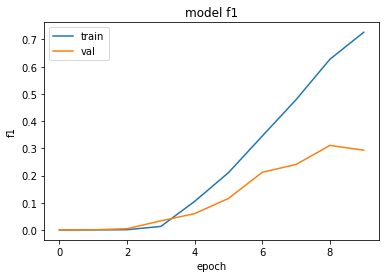

In [18]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

rnn = tf.keras.layers.GRU(128, return_sequences=False)(embeddings)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(rnn)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=10)

print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 1 LSTM layer

Epoch 1/10
43/43 [==============================] - 53s 1s/step - loss: 2.4921 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3198 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/10
43/43 [==============================] - 52s 1s/step - loss: 2.3106 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.2961 - val_f1: 0.0000e+00 - val_rec@prec: 0.0027
Epoch 3/10
43/43 [==============================] - 52s 1s/step - loss: 2.2043 - f1: 0.0071 - rec@prec: 5.9329e-04 - val_loss: 1.9883 - val_f1: 0.0277 - val_rec@prec: 4.5086e-04
Epoch 4/10
43/43 [==============================] - 50s 1s/step - loss: 1.7795 - f1: 0.1769 - rec@prec: 0.0578 - val_loss: 1.6420 - val_f1: 0.3218 - val_rec@prec: 0.1646
Epoch 5/10
43/43 [==============================] - 50s 1s/step - loss: 1.4634 - f1: 0.3782 - rec@prec: 0.2164 - val_loss: 1.5145 - val_f1: 0.4253 - val_rec@prec: 0.2331
Epoch 6/10
43/43 [==============================] - 50s 1s/step - loss: 1.2536 - f1: 0.5601 - rec@prec: 0.3938 - v

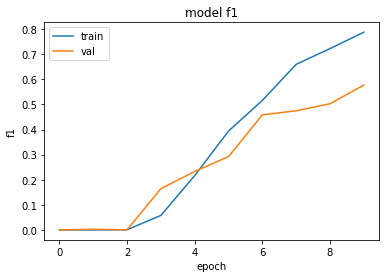

In [20]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

rnn = tf.keras.layers.LSTM(128, return_sequences=False)(embeddings)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(rnn)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=10)

print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 1 GRU and 1 LSTM layer

Epoch 1/10
43/43 [==============================] - 122s 3s/step - loss: 2.4496 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3183 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/10
43/43 [==============================] - 114s 3s/step - loss: 2.2770 - f1: 0.0000e+00 - rec@prec: 2.8478e-04 - val_loss: 2.0577 - val_f1: 6.6600e-04 - val_rec@prec: 0.0171
Epoch 3/10
43/43 [==============================] - 106s 2s/step - loss: 1.8507 - f1: 0.0778 - rec@prec: 0.0481 - val_loss: 1.7683 - val_f1: 0.1549 - val_rec@prec: 0.0703
Epoch 4/10
43/43 [==============================] - 106s 2s/step - loss: 1.6364 - f1: 0.1842 - rec@prec: 0.1022 - val_loss: 1.6784 - val_f1: 0.2015 - val_rec@prec: 0.1118
Epoch 5/10
43/43 [==============================] - 116s 3s/step - loss: 1.5358 - f1: 0.2706 - rec@prec: 0.1276 - val_loss: 1.6461 - val_f1: 0.2689 - val_rec@prec: 0.1199
Epoch 6/10
43/43 [==============================] - 114s 3s/step - loss: 1.3931 - f1: 0.3657 - rec@prec: 0.1896 - val

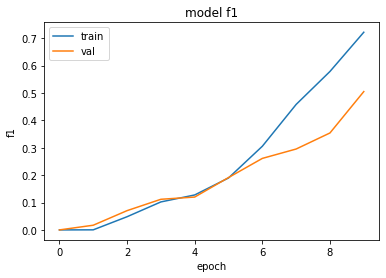

In [22]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm_1 = tf.keras.layers.GRU(128, return_sequences=True)(embeddings)
lstm_2 = tf.keras.layers.LSTM(128, return_sequences=False)(lstm_1)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm_2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=10)

print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 2 LSTM and 1 BIGRU layer

Epoch 1/10
43/43 [==============================] - 242s 5s/step - loss: 2.4265 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3192 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/10
43/43 [==============================] - 233s 5s/step - loss: 2.2116 - f1: 0.0221 - rec@prec: 0.0000e+00 - val_loss: 1.8962 - val_f1: 0.0660 - val_rec@prec: 4.5086e-04
Epoch 3/10
43/43 [==============================] - 250s 6s/step - loss: 1.6425 - f1: 0.3414 - rec@prec: 0.1086 - val_loss: 1.7346 - val_f1: 0.3867 - val_rec@prec: 0.1150
Epoch 4/10
43/43 [==============================] - 248s 6s/step - loss: 1.2775 - f1: 0.5767 - rec@prec: 0.4013 - val_loss: 1.3880 - val_f1: 0.5489 - val_rec@prec: 0.3305
Epoch 5/10
43/43 [==============================] - 273s 6s/step - loss: 1.0901 - f1: 0.6612 - rec@prec: 0.5459 - val_loss: 1.3093 - val_f1: 0.5979 - val_rec@prec: 0.4152
Epoch 6/10
43/43 [==============================] - 288s 7s/step - loss: 1.0018 - f1: 0.6937 - rec@prec: 0.6077 - val_los

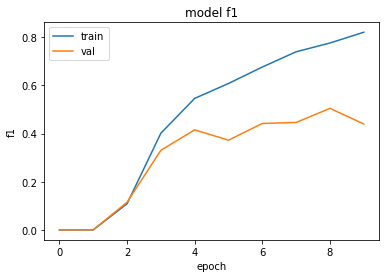

In [26]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

bigru = tf.keras.layers.LSTM(128, return_sequences=True)(embeddings)
lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(bigru)
lstm_2 = tf.keras.layers.LSTM(128, return_sequences=False)(lstm_1)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm_2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=10)

print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 5 GRU and 3 LSTM layer

Epoch 1/10
43/43 [==============================] - 500s 11s/step - loss: 2.4052 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3208 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/10
43/43 [==============================] - 537s 13s/step - loss: 2.3238 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3225 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 3/10
43/43 [==============================] - 509s 12s/step - loss: 2.3249 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3228 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 4/10
43/43 [==============================] - 528s 12s/step - loss: 2.3232 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3189 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 5/10
43/43 [==============================] - 472s 11s/step - loss: 2.3225 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3194 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 6/10
43/43 [==============================] - 471s 11s

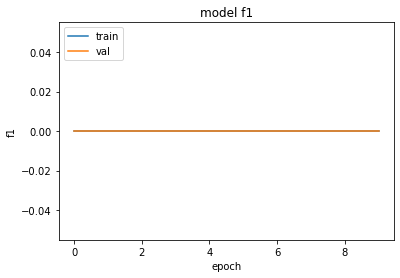

In [28]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

gru_1 = tf.keras.layers.GRU(128, return_sequences=True)(embeddings)
gru_2 = tf.keras.layers.GRU(128, return_sequences=True)(gru_1)
gru_3 = tf.keras.layers.GRU(128, return_sequences=True)(gru_2)
gru_4 = tf.keras.layers.GRU(128, return_sequences=True)(gru_3)
gru_5 = tf.keras.layers.GRU(128, return_sequences=True)(gru_4)
lstm_1 = tf.keras.layers.LSTM(128, return_sequences=True)(gru_5)
lstm_2 = tf.keras.layers.LSTM(128, return_sequences=True)(lstm_1)
lstm_3 = tf.keras.layers.LSTM(128, return_sequences=False)(lstm_2)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm_3)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=10)

print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# BIGRU - BILSTM forward / backforward

Epoch 1/10
43/43 [==============================] - 234s 5s/step - loss: 2.4523 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3017 - val_f1: 0.0000e+00 - val_rec@prec: 0.0104
Epoch 2/10
43/43 [==============================] - 241s 6s/step - loss: 2.1733 - f1: 0.0200 - rec@prec: 4.2717e-04 - val_loss: 1.9281 - val_f1: 6.6600e-04 - val_rec@prec: 0.0077
Epoch 3/10
43/43 [==============================] - 245s 6s/step - loss: 1.7212 - f1: 0.1502 - rec@prec: 0.0833 - val_loss: 1.6569 - val_f1: 0.2118 - val_rec@prec: 0.1380
Epoch 4/10
43/43 [==============================] - 254s 6s/step - loss: 1.4240 - f1: 0.4112 - rec@prec: 0.2474 - val_loss: 1.4187 - val_f1: 0.5427 - val_rec@prec: 0.2809
Epoch 5/10
43/43 [==============================] - 256s 6s/step - loss: 1.1613 - f1: 0.5972 - rec@prec: 0.4531 - val_loss: 1.2611 - val_f1: 0.6000 - val_rec@prec: 0.4166
Epoch 6/10
43/43 [==============================] - 257s 6s/step - loss: 0.9451 - f1: 0.6984 - rec@prec: 0.6316 - val_loss: 1

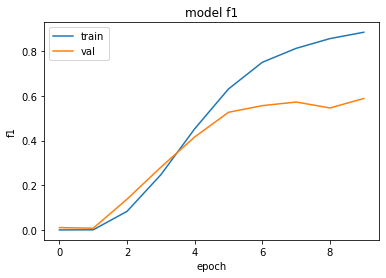

In [33]:


inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

bilstm_forward =  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=False))(embeddings)
bigru_backward =  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=False, go_backwards=True))(embeddings)

hidden = tf.keras.layers.concatenate([bilstm_forward, bigru_backward])

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(hidden)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=10)

print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# LSTM - GRU - BILSTM - BIGRU - GRU - LSTM

Epoch 1/10
43/43 [==============================] - 586s 13s/step - loss: 2.3992 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3196 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/10
43/43 [==============================] - 536s 12s/step - loss: 2.1927 - f1: 0.0105 - rec@prec: 0.0000e+00 - val_loss: 1.9137 - val_f1: 0.1681 - val_rec@prec: 0.0081
Epoch 3/10
43/43 [==============================] - 555s 13s/step - loss: 1.7604 - f1: 0.2066 - rec@prec: 0.0673 - val_loss: 1.7426 - val_f1: 0.2129 - val_rec@prec: 0.1384
Epoch 4/10
43/43 [==============================] - 529s 12s/step - loss: 1.5632 - f1: 0.3203 - rec@prec: 0.1641 - val_loss: 1.6976 - val_f1: 0.3218 - val_rec@prec: 0.1830
Epoch 5/10
43/43 [==============================] - 5462s 130s/step - loss: 1.4717 - f1: 0.4040 - rec@prec: 0.2009 - val_loss: 1.6559 - val_f1: 0.3928 - val_rec@prec: 0.1880
Epoch 6/10
43/43 [==============================] - 15910s 378s/step - loss: 1.4608 - f1: 0.4311 - rec@prec: 0.1957 - 

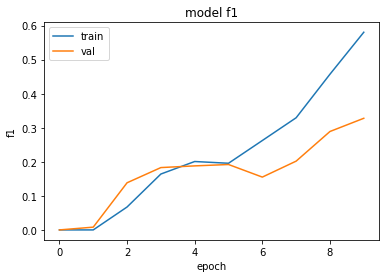

In [29]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm_1 = tf.keras.layers.LSTM(128, return_sequences=True)(embeddings)
gru_1 = tf.keras.layers.GRU(128, return_sequences=True)(lstm_1)
bigru_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(gru_1)
bilstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(bigru_1)
gru_2 = tf.keras.layers.GRU(128, return_sequences=True)(bilstm_1)
lstm_2 = tf.keras.layers.LSTM(128, return_sequences=False)(gru_2)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm_2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=10)

print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 50 GRU layers

In [166]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

gru = tf.keras.layers.GRU(128, return_sequences=True)(embeddings)
for i in range(48):
    gru = tf.keras.layers.GRU(128, return_sequences=True)(gru)
gru = tf.keras.layers.GRU(128, return_sequences=False)(gru)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(gru)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=5)

print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Epoch 1/5


ValueError: in user code:

    File "/Users/e.rykov/.local/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/Users/e.rykov/.local/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/e.rykov/.local/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/Users/e.rykov/.local/lib/python3.8/site-packages/keras/engine/training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "/Users/e.rykov/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/e.rykov/.local/lib/python3.8/site-packages/keras/engine/input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_25" is incompatible with the layer: expected shape=(None, 54), found shape=(None, 200)


Лучший результат на BIGRU BILSTM backforward / forward

## Задание 2 (6 баллов)


На данных википедии (wikiann) обучите 2 модели:  
1) модель в которой будут использованы предобученные эмбединги слов и несколько BILSTM слоев. 
1) модель в которой будут использованы предобученные эмбединги слов и несколько BIGRU слоев. 

Сравните качество по метрикам. Также придумайте несколько сложных примеров и проверьте, какие сущности определяет каждая из моделей.

In [39]:
from datasets import load_dataset

In [42]:
dataset = load_dataset("wikiann", 'ru')

Downloading:   0%|          | 0.00/234M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset wikiann downloaded and prepared to /Users/e.rykov/.cache/huggingface/datasets/wikiann/ru/1.1.0/4bfd4fe4468ab78bb6e096968f61fab7a888f44f9d3371c2f3fea7e74a5a354e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [87]:
# словарь
vocab = Counter()

for sent in dataset['train']['tokens']:
    vocab.update([x.lower() for x in sent])
    
# индексируем слова
word2id = {'PAD':0, 'UNK':1}

for word in vocab:
    word2id[word] = len(word2id)
    
id2word = {i:word for word, i in word2id.items()}

In [91]:
import gensim

ft = gensim.models.fasttext.FastTextKeyedVectors.load('../../../213/model.model')

In [135]:
weight_matrix = np.zeros((len(word2id), 300))
for word, i in word2id.items():
    try:
        embedding_vector = ft[word]
        weight_matrix[i] = embedding_vector
    except KeyError:
        weight_matrix[i] = np.random.uniform(-5, 5, 300)

In [137]:
type(weight_matrix[0])

numpy.ndarray

In [120]:
# переводим тексты в последовательности индексов
X = []

for sent in dataset['train']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

# переводим тексты в последовательности индексов
X_test = []

for sent in dataset['test']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_test.append(ids)

In [121]:
MAX_LEN = max(len(x) for x in X)

# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN, padding='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN, padding='post')

In [122]:
id2labels = {0:'O', 1:'B-PER', 2:'I-PER', 3:'B-ORG', 4:'I-ORG', 5: 'B-LOC', 6:'I-LOC', 7:'PAD'}
label2id = {v:k for k,v in id2labels.items()} 

In [123]:
y = tf.keras.preprocessing.sequence.pad_sequences(dataset['train']['ner_tags'], value=7,
                                                  maxlen=MAX_LEN,  padding='post')
y_test = tf.keras.preprocessing.sequence.pad_sequences(dataset['test']['ner_tags'], value=7,
                                                       maxlen=MAX_LEN,  padding='post')

In [124]:
MAX_LEN

54

In [125]:
X.shape, X_test.shape

((20000, 54), (10000, 54))

In [126]:
y.shape, y_test.shape

((20000, 54), (10000, 54))

In [127]:
len(ft.vectors)

154923

In [152]:
import re

def tokenize(text, word2id):
    # токенизирует и переводит в индексы
    tokens = re.findall('\w+|[^\w\s]+', text)
    ids = [word2id.get(token.lower(), 1) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):
    # декодирует индексы в части речи
    # length нужно чтобы откидывать паддинги или некорректные предсказания
    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(tf.keras.preprocessing.sequence.pad_sequences([ids], 
                                                                       maxlen=max_len, 
                                                                       padding='post'))
    labels = pred2tags(pred, id2label, len(ids))
    
    return list(zip(tokens, labels))

Epoch 1/5
157/157 [==============================] - 102s 591ms/step - loss: 0.1786 - accuracy: 0.9432 - val_loss: 0.1235 - val_accuracy: 0.9600
Epoch 2/5
157/157 [==============================] - 109s 696ms/step - loss: 0.0730 - accuracy: 0.9762 - val_loss: 0.0931 - val_accuracy: 0.9740
Epoch 3/5
157/157 [==============================] - 108s 689ms/step - loss: 0.0477 - accuracy: 0.9849 - val_loss: 0.0976 - val_accuracy: 0.9750
Epoch 4/5
157/157 [==============================] - 106s 676ms/step - loss: 0.0404 - accuracy: 0.9872 - val_loss: 0.0917 - val_accuracy: 0.9773
Epoch 5/5
157/157 [==============================] - 96s 611ms/step - loss: 0.0359 - accuracy: 0.9887 - val_loss: 0.0901 - val_accuracy: 0.9762


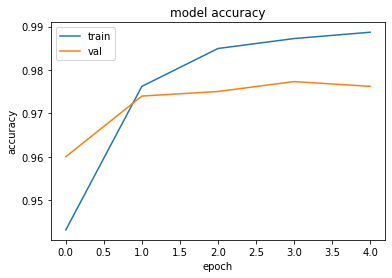

In [150]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,)) 

embeddings = tf.keras.layers.Embedding(len(word2id),
                        300,
                        weights=[weight_matrix],
                        input_length=MAX_LEN,
                        trainable=False)(inputs)

lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embeddings)
lstm_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(lstm_1)
lstm_3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=False))(lstm_2)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm_3)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])

model.fit(X, y, 
          validation_data=(X_test, y_test),
          batch_size=128,
         epochs=5)

plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [160]:
label_seq('Завтра Маша Василькина пойдет на пару в ВШЭ. Университет "вышка" располагается на Мясницкой улице.', word2id, id2labels, MAX_LEN, model)

[('Завтра', 'O'),
 ('Маша', 'B-LOC'),
 ('Василькина', 'O'),
 ('пойдет', 'O'),
 ('на', 'O'),
 ('пару', 'O'),
 ('в', 'O'),
 ('ВШЭ', 'B-ORG'),
 ('.', 'O'),
 ('Университет', 'I-ORG'),
 ('"', 'O'),
 ('вышка', 'O'),
 ('"', 'O'),
 ('располагается', 'O'),
 ('на', 'O'),
 ('Мясницкой', 'O'),
 ('улице', 'O'),
 ('.', 'O')]

Epoch 1/5
157/157 [==============================] - 80s 473ms/step - loss: 0.1360 - accuracy: 0.9546 - val_loss: 0.1169 - val_accuracy: 0.9648
Epoch 2/5
157/157 [==============================] - 75s 477ms/step - loss: 0.0505 - accuracy: 0.9837 - val_loss: 0.1161 - val_accuracy: 0.9675
Epoch 3/5
157/157 [==============================] - 85s 540ms/step - loss: 0.0408 - accuracy: 0.9869 - val_loss: 0.1186 - val_accuracy: 0.9686
Epoch 4/5
157/157 [==============================] - 87s 552ms/step - loss: 0.0358 - accuracy: 0.9886 - val_loss: 0.1231 - val_accuracy: 0.9676
Epoch 5/5
157/157 [==============================] - 87s 557ms/step - loss: 0.0316 - accuracy: 0.9899 - val_loss: 0.1233 - val_accuracy: 0.9674


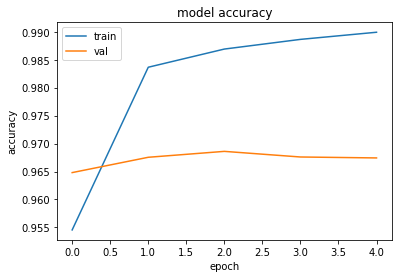

In [162]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,)) 
embeddings = tf.keras.layers.Embedding(len(word2id),
                        300,
                        weights=[weight_matrix],
                        input_length=MAX_LEN,
                        trainable=False)(inputs)

gru_1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embeddings)
gru_2 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(gru_1)
gru_3 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(gru_2)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(gru_3)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])

model.fit(X, y, 
          validation_data=(X_test, y_test),
          batch_size=128,
         epochs=5)

plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [163]:
label_seq('Завтра Маша Василькина пойдет на пару в ВШЭ. Университет "вышка" располагается на Мясницкой улице.', word2id, id2labels, MAX_LEN, model)

[('Завтра', 'I-PER'),
 ('Маша', 'B-LOC'),
 ('Василькина', 'PAD'),
 ('пойдет', 'PAD'),
 ('на', 'O'),
 ('пару', 'O'),
 ('в', 'O'),
 ('ВШЭ', 'B-ORG'),
 ('.', 'I-ORG'),
 ('Университет', 'I-ORG'),
 ('"', 'O'),
 ('вышка', 'O'),
 ('"', 'O'),
 ('располагается', 'O'),
 ('на', 'O'),
 ('Мясницкой', 'O'),
 ('улице', 'O'),
 ('.', 'O')]

В качестве предобученных эмбеддингов взял FastText из RusVectores. Accuracy выше у первой модели, обе делают ошибку в токенах "завтра", "Маша", "Василькина", "Мясницкая", но распознают "ВШЭ"